# Seasonal Decomposition and Detrending

In [1]:
import statsmodels.api as sm

import scipy
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

import yfinance

In [2]:
ticker = 'JETS' #'JETS'  
data = pd.DataFrame()
data[ticker] = yfinance.download(ticker, end='2020-1-1')['Adj Close'] # , start='2015-1-1'
data.head()

[*********************100%***********************]  1 of 1 completed


,JETS
Date,
2015-04-30,23.199871
2015-05-01,23.854010
2015-05-04,23.652584
2015-05-05,23.019548
2015-05-06,23.000368


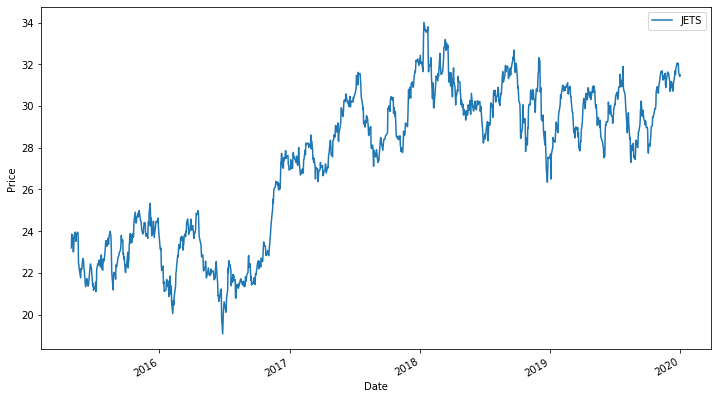

In [3]:
data.plot(figsize=(12, 7))
plt.ylabel("Price");

## Using Statsmodels to get the trend
The Hodrick-Prescott filter separates a time-series  y_t  into a trend  τ_t and a cyclical component  ζt

$y_t = \tau_t + \zeta_t$

The components are determined by minimizing the following quadratic loss function

$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$

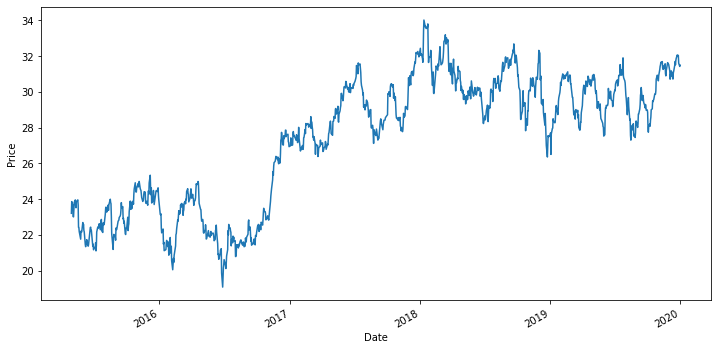

In [4]:
data[ticker].plot(figsize=(12, 6))
plt.ylabel("Price");

### Hodrick–Prescott decomposition is a mathematical tool used to remove the cyclical component of a time series from raw data
> Stock = Trend + Cycle


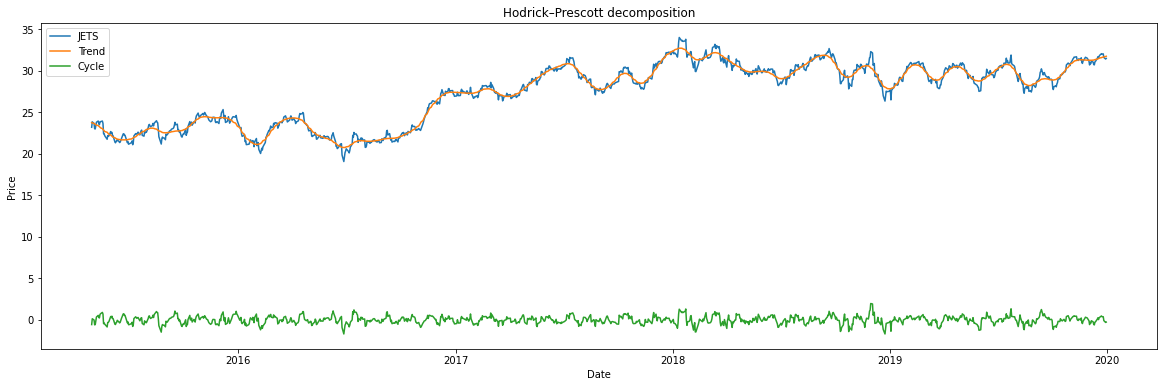

In [5]:
cycle, trend = sm.tsa.filters.hpfilter(data[ticker])
plt.figure(figsize=(20,6))
plt.plot(data[ticker], label = ticker)
plt.plot(trend, label = "Trend")
plt.plot(cycle, label = "Cycle")

plt.legend()
plt.ylabel("Price")
plt.xlabel("Date")
plt.title("Hodrick–Prescott decomposition");

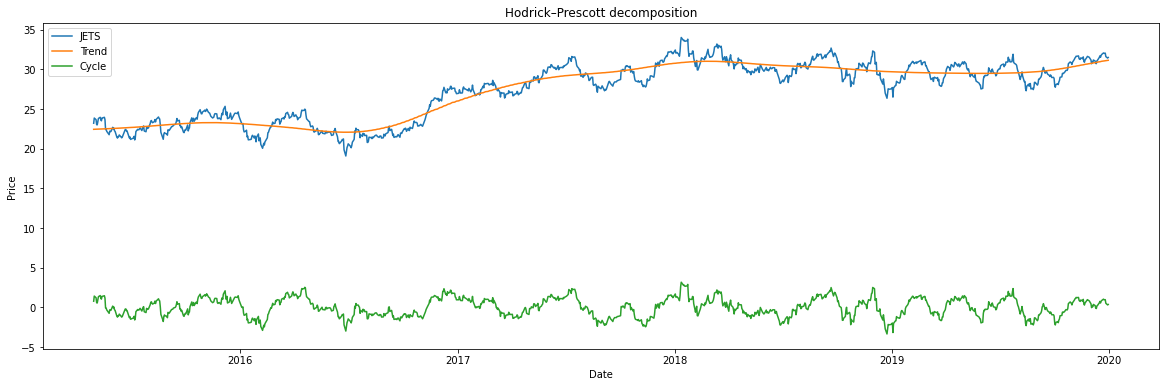

In [6]:
# cycle, trend = sm.tsa.filters.hpfilter(data[ticker], 10000000)

cycle, trend = sm.tsa.filters.hpfilter(data[ticker], 30* 1600*3**4) # from the docs.  shift+tab

plt.figure(figsize=(20,6))
plt.plot(data[ticker], label = ticker)
plt.plot(trend, label = "Trend")
plt.plot(cycle, label = "Cycle")

plt.legend()
plt.ylabel("Price")
plt.xlabel("Date")
plt.title("Hodrick–Prescott decomposition");

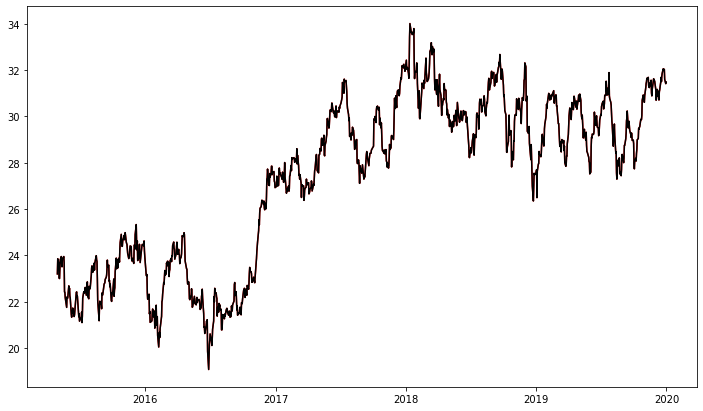

In [7]:
plt.figure(figsize=(12,7))
plt.plot(cycle + trend, c='red')
# plt.plot(cycle + trend + 1, c='red')
plt.plot(data[ticker], c='black')
plt.show()

## Let's try statsmodels.tsa.seasonal import seasonal_decompose

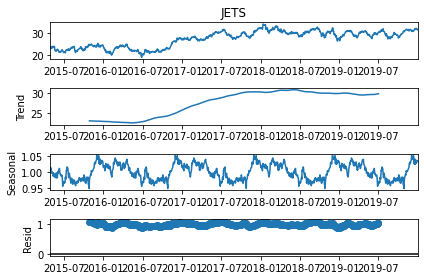

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
tsla = data[ticker]

result = seasonal_decompose(tsla, model='multiplicative', period = 252);
_ = result.plot()

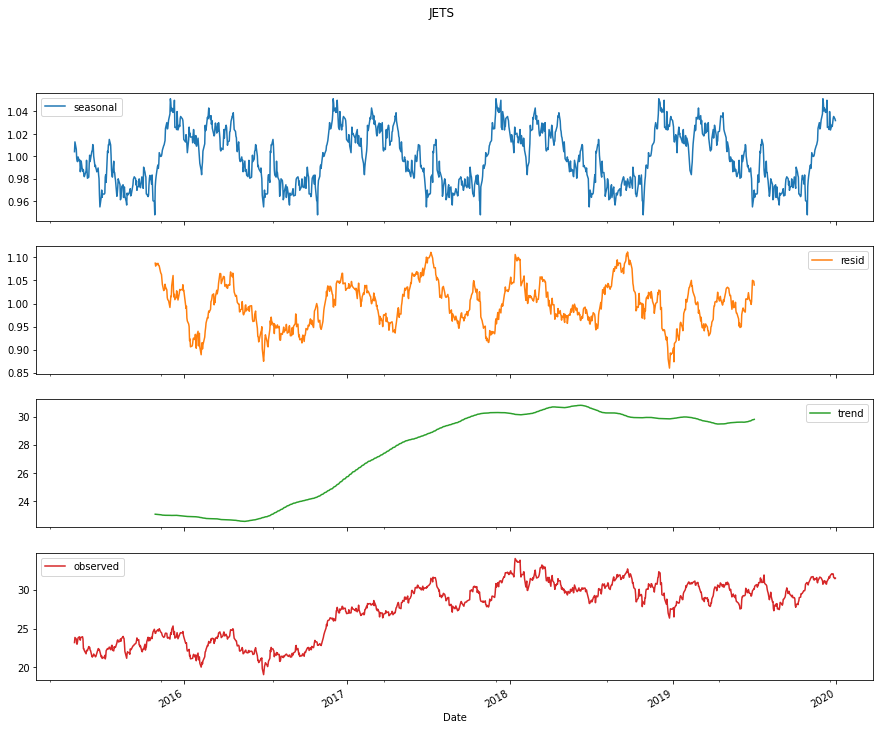

In [9]:
df = pd.DataFrame({
    "seasonal":result.seasonal.values,
    "resid":result.resid,
    "trend":result.trend,
    "observed":data[ticker]})

# df = df.fillna(df.mean()) # very stupid. i've learn alot since 2 years ago
# df['seasonal'] = MinMaxScaler().fit_transform(df[['seasonal']])
# df['resid'] = MinMaxScaler().fit_transform(df[['resid']])
# df['observed'] = MinMaxScaler().fit_transform(df[['observed']])
# df['trend'] = MinMaxScaler().fit_transform(df[['trend']])

# df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df.plot(title=ticker, figsize=(15,12), subplots=(4,1));

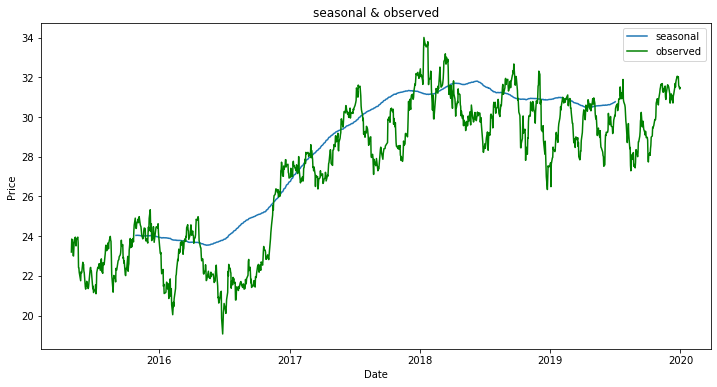

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.trend + df.seasonal, label = 'seasonal')
plt.plot(df.observed, label = 'observed', color='green')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.title("seasonal & observed");

In [11]:
corr, pVal = scipy.stats.spearmanr(df.seasonal, df.observed) # pearsonr

print(f"Corr is: {corr:.2f}")
print(f"pVal is: {pVal:.2f}")

if (pVal <  0.05):
   print("P-value is significant! There is a correlation, ", pVal)
   print("Given our significance level of α = 0.05, There is sufficient evidence to conclude that there is a significant linear relationship between x and y because the correlation coefficient is significantly different from 0.")

Corr is: 0.20
pVal is: 0.00
P-value is significant! There is a correlation,  7.420080571890579e-12
Given our significance level of α = 0.05, There is sufficient evidence to conclude that there is a significant linear relationship between x and y because the correlation coefficient is significantly different from 0.


## Let's try subtracting the {Linear Reg, Polynomial Reg, Nth-MA}  

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = np.array(range(data[ticker].shape[0])).reshape(-1,1)
y = data[ticker]

def ploy(degree = 2):
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = LinearRegression()
    clf.fit(X_, y)
    return clf.predict(X_)

OLS_pred    = ploy(1)
POLY_pred_2 = ploy(2)
POLY_pred_9 = ploy(9)

MA_40 = data[ticker].rolling(40).mean().fillna(20).values
# MA_80 = data[ticker].rolling(80).mean().fillna(20).values

TSLA = data[ticker].values

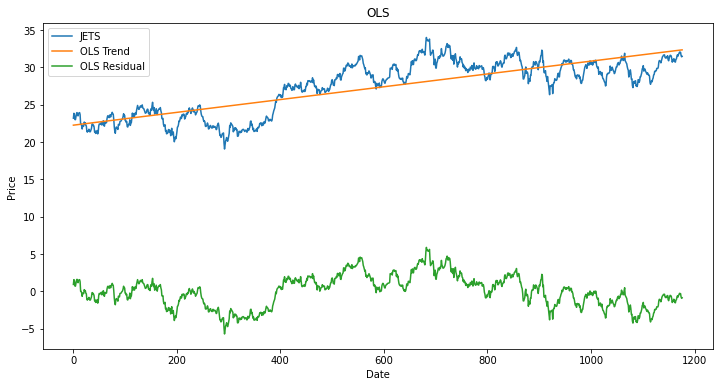

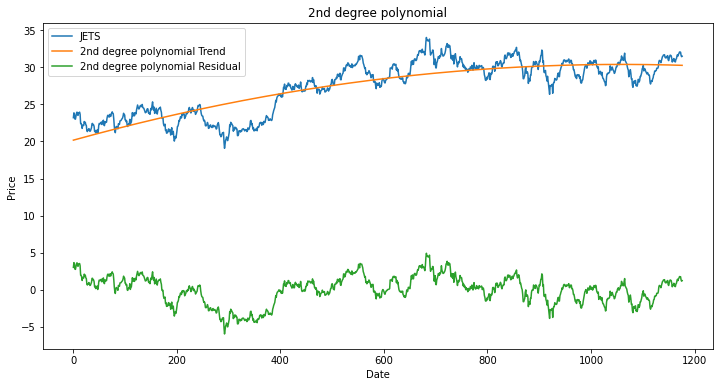

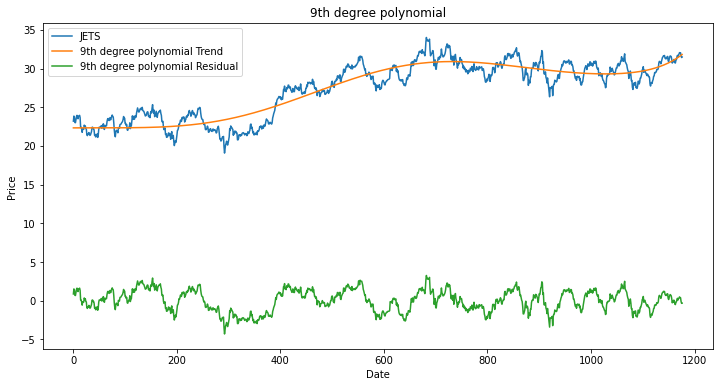

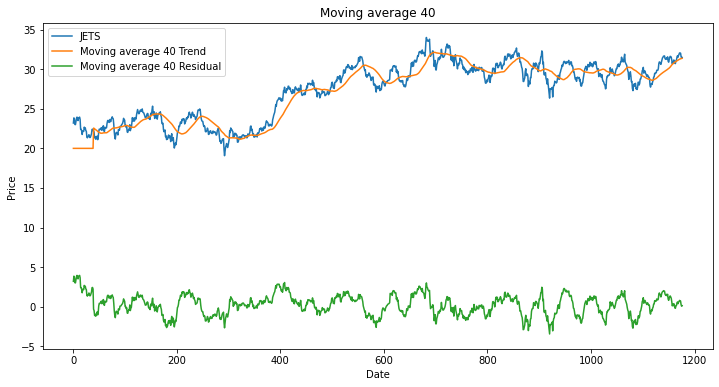

In [13]:
def plot_stuff(stonk, trendy_boi, name):
    plt.figure(figsize=(12,6))
    plt.plot(stonk, label = ticker)

    plt.plot(trendy_boi, label = name+" Trend")
    plt.plot(stonk - trendy_boi, label = name+" Residual")

    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend()
    plt.title(name);

    
plot_stuff(TSLA, OLS_pred, name= 'OLS')
plot_stuff(TSLA, POLY_pred_2, name= '2nd degree polynomial')
plot_stuff(TSLA, POLY_pred_9, name= '9th degree polynomial')
plot_stuff(TSLA, MA_40, name= 'Moving average 40')

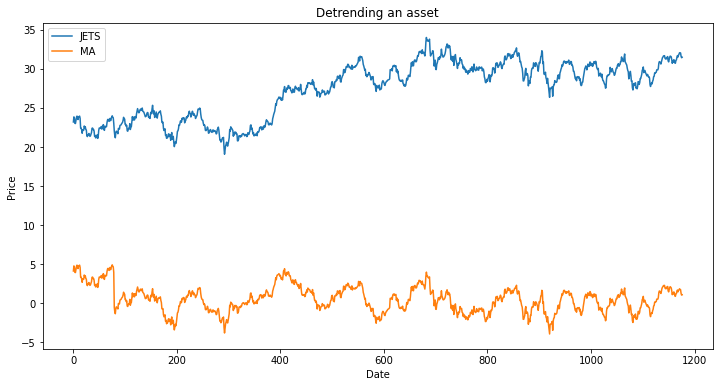

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(TSLA, label = ticker)

# tester for MA 
plt.plot(TSLA - data.rolling(80).mean().fillna(TSLA.min()).values.flatten(), label = 'MA')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.title("Detrending an asset");